<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/Projeto_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem definition

Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:

  1) Location

  2) Tweet At

  3) Original Tweet

based on: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

In [1]:
! pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.5 MB/s eta 0:00:00


## Imports

In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string

#import emoji
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


###plot config
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


<ipython-input-2-2a083038f008>:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [3]:
def conf_matrix(y, y_pred, title):

    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [8]:
!wget 'https://github.com/HumaSejdini/NLP-CoronaTweets/blob/master/Corona_NLP_train%20(1).csv'

--2024-02-01 19:23:35--  https://github.com/HumaSejdini/NLP-CoronaTweets/blob/master/Corona_NLP_train%20(1).csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4579 (4.5K) [text/plain]
Saving to: ‘Corona_NLP_train (1).csv’

Corona_NLP_train (1 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-02-01 19:23:36 (67.9 MB/s) - ‘Corona_NLP_train (1).csv’ saved [4579/4579]



## Loading datasets

https://github.com/HumaSejdini/NLP-CoronaTweets/blob/master/Corona_NLP_test%20(1).csv

In [11]:
df_train = pd.read_csv(
    'Corona_NLP_train (1).csv',
    encoding='ISO-8859-1'
    )

df_test = pd.read_csv(
     'Corona_NLP_test (1).csv'
     )

In [12]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
df_train.OriginalTweet.iloc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [14]:
df_train.OriginalTweet.iloc[1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [15]:
df_train.OriginalTweet.iloc[2]

'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P'

In [16]:
df_train.shape

(41157, 6)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


## EDA of features

In [18]:
## Transform 'TweetAt' into datetime
df_train = df_train.assign(
  dt_t0 = lambda df_: pd.to_datetime(df_['TweetAt'])
)

<ipython-input-18-b3d2f3973c8a>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dt_t0 = lambda df_: pd.to_datetime(df_['TweetAt'])


In [19]:
df_train.dt_t0.value_counts()

2020-03-20    3448
2020-03-19    3215
2020-03-25    2979
2020-03-18    2742
2020-03-21    2653
2020-03-22    2114
2020-03-23    2062
2020-03-17    1977
2020-08-04    1881
2020-07-04    1843
2020-06-04    1742
2020-03-24    1480
2020-09-04    1471
2020-04-13    1428
2020-03-26    1277
2020-05-04    1131
2020-10-04    1005
2020-02-04     954
2020-11-04     909
2020-03-04     810
2020-12-04     803
2020-04-04     767
2020-03-16     656
2020-01-04     630
2020-03-27     345
2020-03-31     316
2020-04-14     284
2020-03-29     125
2020-03-30      87
2020-03-28      23
Name: dt_t0, dtype: int64

In [20]:
df_train.dt_t0.min()

Timestamp('2020-01-04 00:00:00')

In [21]:
df_train.dt_t0.max()

Timestamp('2020-12-04 00:00:00')

In [22]:
tweets_per_day = df_train['dt_t0'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')
tweets_per_day

,index,counts
0,01-04,630
1,02-04,954
2,03-04,810
3,03-16,656
4,03-17,1977
5,03-18,2742
6,03-19,3215
7,03-20,3448
8,03-21,2653
9,03-22,2114


### Tweets per **date**

<ipython-input-23-d12ec74291b4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tweets_per_day['index'], rotation=45, ha='right')


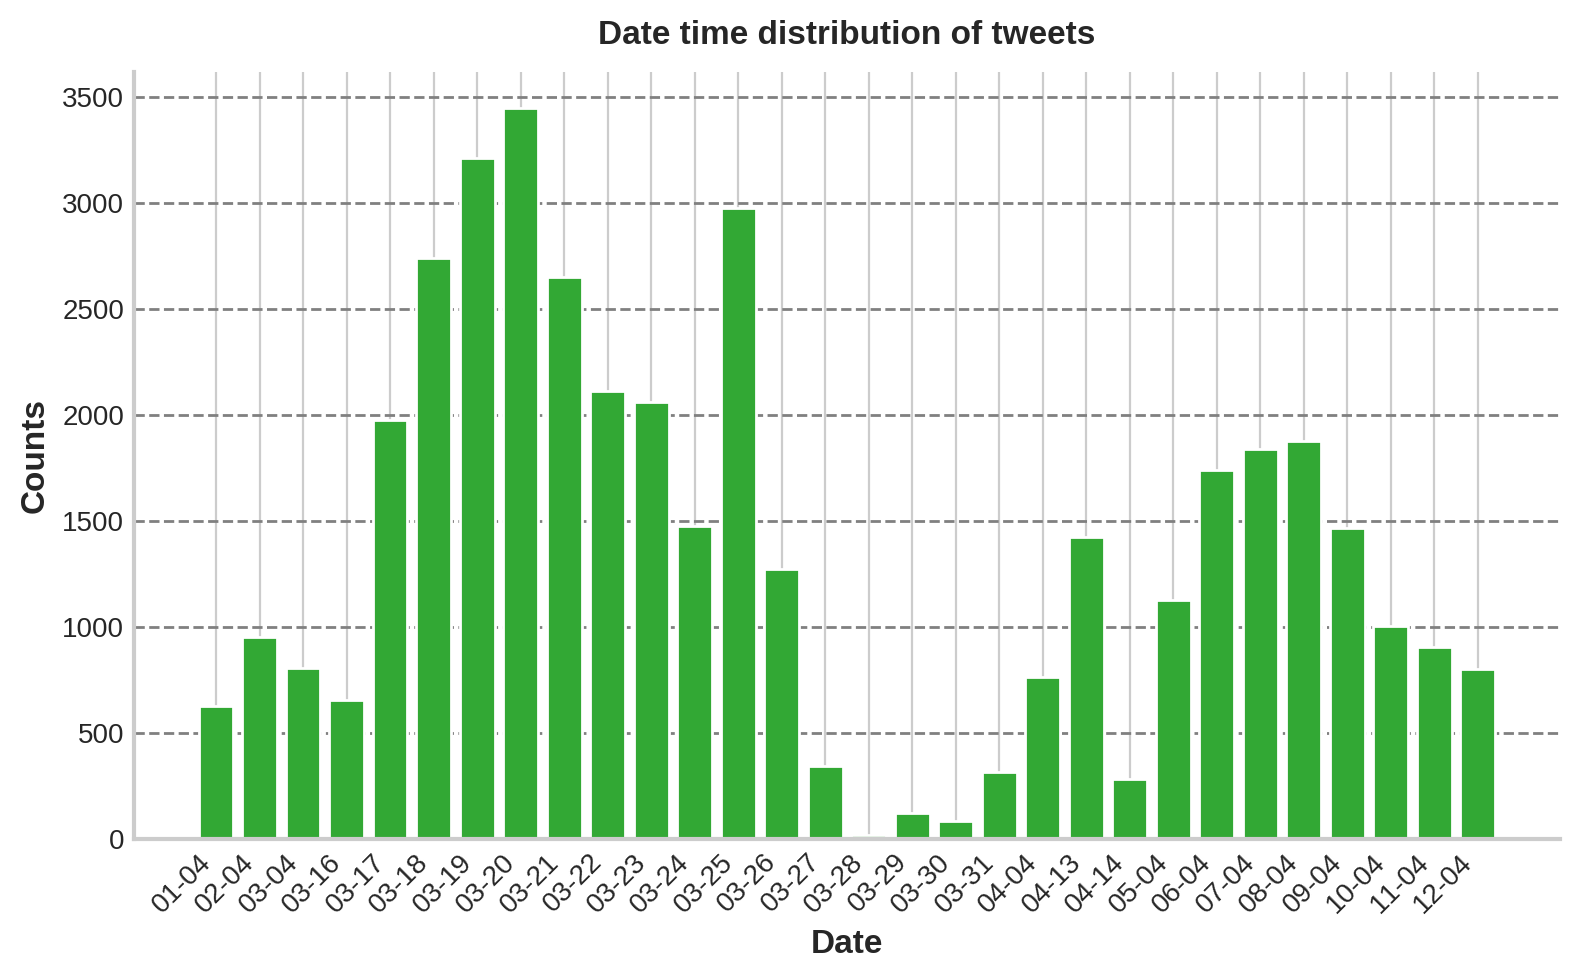

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_per_day['index'], tweets_per_day['counts'], color="#32a834")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xticklabels(tweets_per_day['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('Counts')
ax.set_title('Date time distribution of tweets')
#ax.legend(title='Fruit color')

plt.show()

In [24]:
tweets_per_country = df_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')
tweets_per_country

,index,counts
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


## Tweets per location

<ipython-input-25-a1c5990fa615>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')


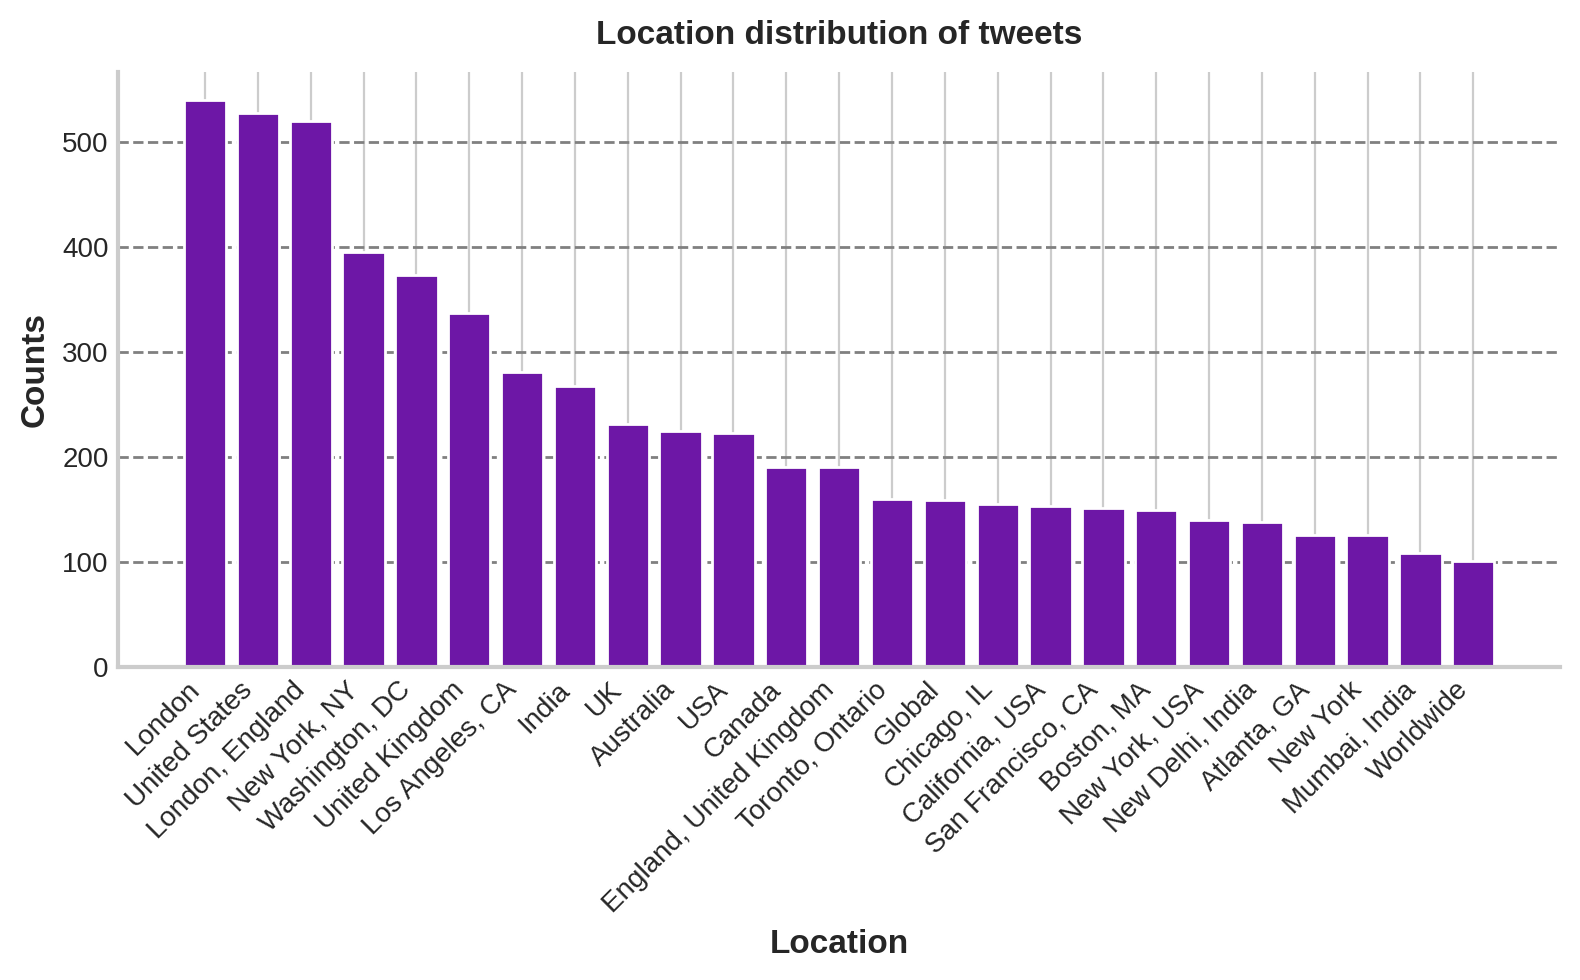

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_per_country['index'], tweets_per_country['counts'], color="#6d17a6") #mudar a cor

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Location')
ax.set_ylabel('Counts')
ax.set_title('Location distribution of tweets')

plt.show()

# Pre processing text

In [26]:
selected_features = ['OriginalTweet','Sentiment']
df_train = df_train[selected_features]
df_test = df_test[selected_features]

## Custom Functions

In [27]:
#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new_train = []
for t in df_train.OriginalTweet:
    texts_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
df_train['text_clean'] = texts_new_train
df_test['text_clean'] = texts_new_test

In [ ]:
df_train.OriginalTweet.iloc[0]

In [ ]:
df_train.text_clean.iloc[0]

In [ ]:
df_train.OriginalTweet.iloc[1]

In [ ]:
df_train.text_clean.iloc[1]

In [ ]:
df_train.OriginalTweet.iloc[3]

In [ ]:
df_train.text_clean.iloc[3]

Here we could see that some tweets only had mentions and links, which we could filter by size:

In [ ]:
text_len_train = []
for text in df_train.text_clean:
    tweet_len_train = len(text.split())
    text_len_train.append(tweet_len_train)

text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
# Creating a column with the new values
df_train['text_len'] = text_len_train
df_test['text_len'] = text_len_test

In [ ]:
df_train[df_train['text_len']<10]['text_len'].value_counts()

In [ ]:
df_train[df_train['text_len']>10]['text_len'].value_counts().sum()

In [ ]:
tweets_len = df_train[df_train['text_len']<10]['text_len'].value_counts().reset_index(name='counts')
tweets_len

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_len['index'].values, tweets_len['counts'].values, color="#6d17a6")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
#ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Len')
ax.set_ylabel('Counts')
ax.set_title('Len distribution of tweets')

plt.show()

Here we can see that there are a few tweets with a small size, which are probably disconnected words as a result of the cleaning we've done, because of this we will only filter tweets longer than 4 words

In [ ]:
print(f" DF SHAPE: {df_train.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

In [ ]:
df_train = df_train[df_train['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE AFTER FILTER: {df_train.shape}")
print(f" DF TEST SHAPE AFTER FILTER: {df_test.shape}")

## Deeper Cleaning with Bert

In [ ]:
# Using Bert Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []
for txt in df_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

In [ ]:
token_lens = []
for i,txt in enumerate(df_train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

These sentences are not in english. They should be dropped.

In [ ]:
df_train['token_lens'] = token_lens
df_train = df_train.sort_values(by='token_lens', ascending=False)
df_train.head(20)

In [ ]:
df_train = df_train.iloc[15:]
df_train.head()

In [ ]:
df_train.shape

In [ ]:
df_train = df_train.sample(frac=0.2).reset_index(drop=True)


In [ ]:
df_train.shape

## Sentiment Colum Analysis

In [ ]:
df_train['Sentiment'].value_counts()

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [ ]:
df_train['Sentiment'] = df_train['Sentiment'].map(
    {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2, 'Extremely Pos':2}
    )

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map(
    {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2}
    )

In [ ]:
df_train['Sentiment'].value_counts()

In [ ]:
df_test['Sentiment'].value_counts()

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [ ]:
np.array(df_train['text_clean']).reshape(-1, 1)

In [ ]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(
    np.array(df_train['text_clean']).reshape(-1, 1),
    np.array(df_train['Sentiment']).reshape(-1, 1)
  )

train_x

In [ ]:
train_x[0]

In [ ]:
train_os = pd.DataFrame(
    list(zip([x[0] for x in train_x], train_y)),
    columns = ['text_clean', 'Sentiment']
    )
train_os

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

### One Hot Enconding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

# Baseline Model: Naive Bayes

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Here we use the tfidf transform as a feature for our baseline model

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)

X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
X_train_tf[0].toarray()

In [ ]:
len(X_train_tf[0].toarray().reshape(-1,1))

In [ ]:
[x for x in X_train_tf[0].toarray().reshape(-1,1) if x!=0]

## Model

In [ ]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train_le)

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print(
    '\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive'])
    )

# BERT

In [ ]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

## Model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    # define optimizer
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)

    # define loss
    loss = tf.keras.losses.CategoricalCrossentropy()

    # evaluate model accuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # define model entry
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    # separate embeddings
    embeddings = bert_model([input_ids,attention_masks])[1]

    # create a new layer for class prediction
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    # compiles the model
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

In [ ]:
history_bert = model.fit(
    [train_input_ids,train_attention_masks],
    y_train,
    validation_data=([val_input_ids,val_attention_masks], y_valid),
    epochs=1,
    batch_size=42
                         )

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))